In [1]:
# =============================================================================
# Created By:     Kai Metzger
# Created School: Franz-Oberthuer-Schule Wuerzburg
# Created Email:  metzgerkai@franz-oberthuer-schule.de
# Created Date:   Sat April 05 09:54 UTC 2025
# Version:        1.0.1
# =============================================================================
"""The Module has been build for training the symbols dataset with images + 
ground truth. Images have the base dimenstions of 640px x 480px in datasets 1-8
and then another 700 images with resolution 1920px x 1080px have been added to  
the subsequent datasets.
The files in the dataset <symbols> should be ordered in the following
manner:             > explanation
- symbols      
  - dataset1        > dataset version (dataset1 - 3 where used in the project)
    - data          > images (.png files)
    - gt            > ground truth (.txt files with class labels 1-4)

  - dataset10 the corresponding classes are stored in folders 0 - 3:
    - 0             = cross
    - 1             = circle 
    - 2             = triangle
    - 3             = rectangle
"""

# =============================================================================
# Import
# =============================================================================
import cv2
import os
import numpy as np
from keras import layers, models, utils, callbacks
import matplotlib.pyplot as plt
import keras
import tensorflow as tf
import tensorflow_hub as hub
from keras.optimizers.schedules import ExponentialDecay

# Enable Nvidia GPUs by un-commenting this line 
os.environ['CUDA_VISIBLE_DEVICES'] = "0"
XLA_FLAGS="--xla_gpu_cuda_data_dir=/usr/"


2025-11-29 13:23:49.765881: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/kai/.local/lib/python3.12/site-packages/tensorflow_hub/__init__.py:61: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import parse_version


In [2]:
# =============================================================================
# Declare variables
# =============================================================================
# Change the following paths to your dataset path
home_dir = os.path.expanduser("~/git")
dataset_for_training = home_dir + "/ml_project/datasets/symbols/dataset10"
dataset_for_training = home_dir + "/ml_project/datasets/dogs/dataset10"
print(dataset_for_training)

/home/kai/git/ml_project/datasets/dogs/dataset10


In [3]:
# =============================================================================
# Dataset related
# =============================================================================
NUM_CLASSES = 4
IMG_SIZE_X = 160
IMG_SIZE_Y = 160
IMG_SIZE = (IMG_SIZE_X, IMG_SIZE_Y)
#INPUT_SHAPE = (IMG_SIZE_X, IMG_SIZE_Y, 1) # grayscale
INPUT_SHAPE = (IMG_SIZE_X, IMG_SIZE_Y, 3) # color

# =============================================================================
# Hyperparameters
# =============================================================================
BATCH_SIZE = 32
EPOCHS = 300
LEARNING_RATE = 0.001

# Set up an exponential decay learning rate schedule
LR_SCHEDULE = ExponentialDecay(
    initial_learning_rate=LEARNING_RATE,  # start with 0.001
    decay_steps=100000,           # how often to apply the decay
    decay_rate=0.96,              # decay rate
    staircase=True                # whether to apply the decay in steps
)

OPTIMIZER = keras.optimizers.Adam(learning_rate=LR_SCHEDULE)

I0000 00:00:1764419032.813370   40106 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4617 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1660 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5


In [4]:
#_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
#path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = "/home/kai/git/ml_project/datasets/cats_and_dogs_filtered"

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

print(train_dir)
print(validation_dir)

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)


/home/kai/git/ml_project/datasets/cats_and_dogs_filtered/train
/home/kai/git/ml_project/datasets/cats_and_dogs_filtered/validation
Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [5]:
# =============================================================================
# Dataset
# =============================================================================
"""resize_and_rescale_grayscale = tf.keras.Sequential([
    layers.Lambda(lambda x: tf.image.rgb_to_grayscale(x)),  # Convert to grayscale
    layers.Resizing(IMG_SIZE_X, IMG_SIZE_Y),        # Resize image to the target size
    layers.Rescaling(1./255)                        # Rescale pixel values to [0, 1]
])
"""

'resize_and_rescale_grayscale = tf.keras.Sequential([\n    layers.Lambda(lambda x: tf.image.rgb_to_grayscale(x)),  # Convert to grayscale\n    layers.Resizing(IMG_SIZE_X, IMG_SIZE_Y),        # Resize image to the target size\n    layers.Rescaling(1./255)                        # Rescale pixel values to [0, 1]\n])\n'

In [6]:
"""train_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_for_training,
    shuffle=True,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(IMG_SIZE_X, IMG_SIZE_Y),
    batch_size=BATCH_SIZE)
"""

'train_ds = tf.keras.utils.image_dataset_from_directory(\n    dataset_for_training,\n    shuffle=True,\n    validation_split=0.2,\n    subset="training",\n    seed=123,\n    image_size=(IMG_SIZE_X, IMG_SIZE_Y),\n    batch_size=BATCH_SIZE)\n'

In [7]:
"""val_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_for_training,
    shuffle=True,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(IMG_SIZE_X, IMG_SIZE_Y),
    batch_size=BATCH_SIZE)
"""

'val_ds = tf.keras.utils.image_dataset_from_directory(\n    dataset_for_training,\n    shuffle=True,\n    validation_split=0.2,\n    subset="validation",\n    seed=123,\n    image_size=(IMG_SIZE_X, IMG_SIZE_Y),\n    batch_size=BATCH_SIZE)\n'

In [8]:
"""
class_names = train_ds.class_names
print(class_names)

print('Number of training batches: %d' % tf.data.experimental.cardinality(train_ds))
print('Number of validation batches: %d' % tf.data.experimental.cardinality(val_ds))
"""

"\nclass_names = train_ds.class_names\nprint(class_names)\n\nprint('Number of training batches: %d' % tf.data.experimental.cardinality(train_ds))\nprint('Number of validation batches: %d' % tf.data.experimental.cardinality(val_ds))\n"

In [9]:
class_names = train_dataset.class_names
print(class_names)

print('Number of training batches: %d' % tf.data.experimental.cardinality(train_dataset))
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))

['cats', 'dogs']
Number of training batches: 63
Number of validation batches: 32


2025-11-29 13:23:54.322647: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


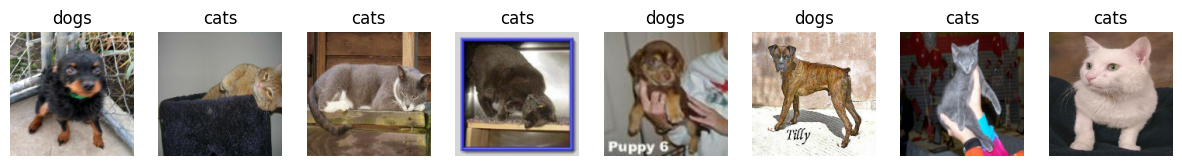

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 15))
for images, labels in train_dataset.take(1):
    for i in range(8):
        ax = plt.subplot(1, 8, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")


In [11]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)


In [12]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))


Number of validation batches: 26
Number of test batches: 6


In [13]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)


In [14]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

2025-11-29 13:23:56.371432: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


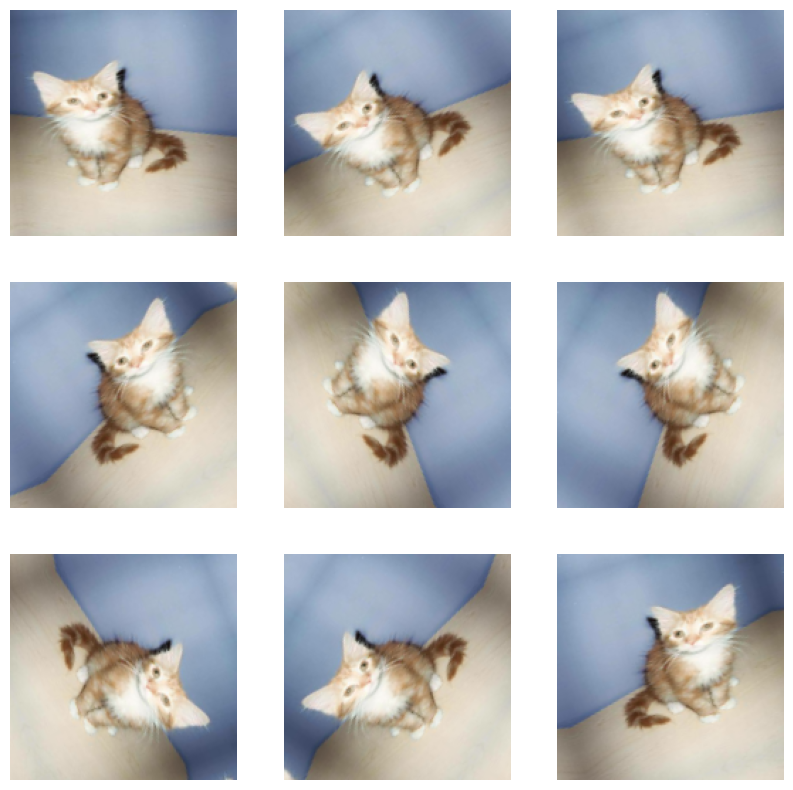

In [15]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')


In [16]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

In [17]:
# Create the base model from the pre-trained model MobileNet V2
#print(IMG_SIZE)
#print(INPUT_SHAPE)
IMG_SHAPE = IMG_SIZE + (3,)
#print(IMG_SHAPE)
base_model = tf.keras.applications.MobileNetV2(input_shape=INPUT_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [18]:
"""
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)
"""

'\nimage_batch, label_batch = next(iter(train_ds))\nfeature_batch = base_model(image_batch)\nprint(feature_batch.shape)\n'

In [19]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

2025-11-29 13:23:57.700099: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91501


(32, 5, 5, 1280)


In [20]:
base_model.trainable = False

In [21]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_160"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 80, 80,    │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 80, 80,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 80, 80,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 80, 80,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 80, 80,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 80, 80,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 80, 80,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 80, 80,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 81, 81,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 40, 40,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 40, 40,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 40, 40,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

In [22]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [23]:
prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)


(32, 1)


In [24]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)


In [25]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [26]:
len(model.trainable_variables)

2

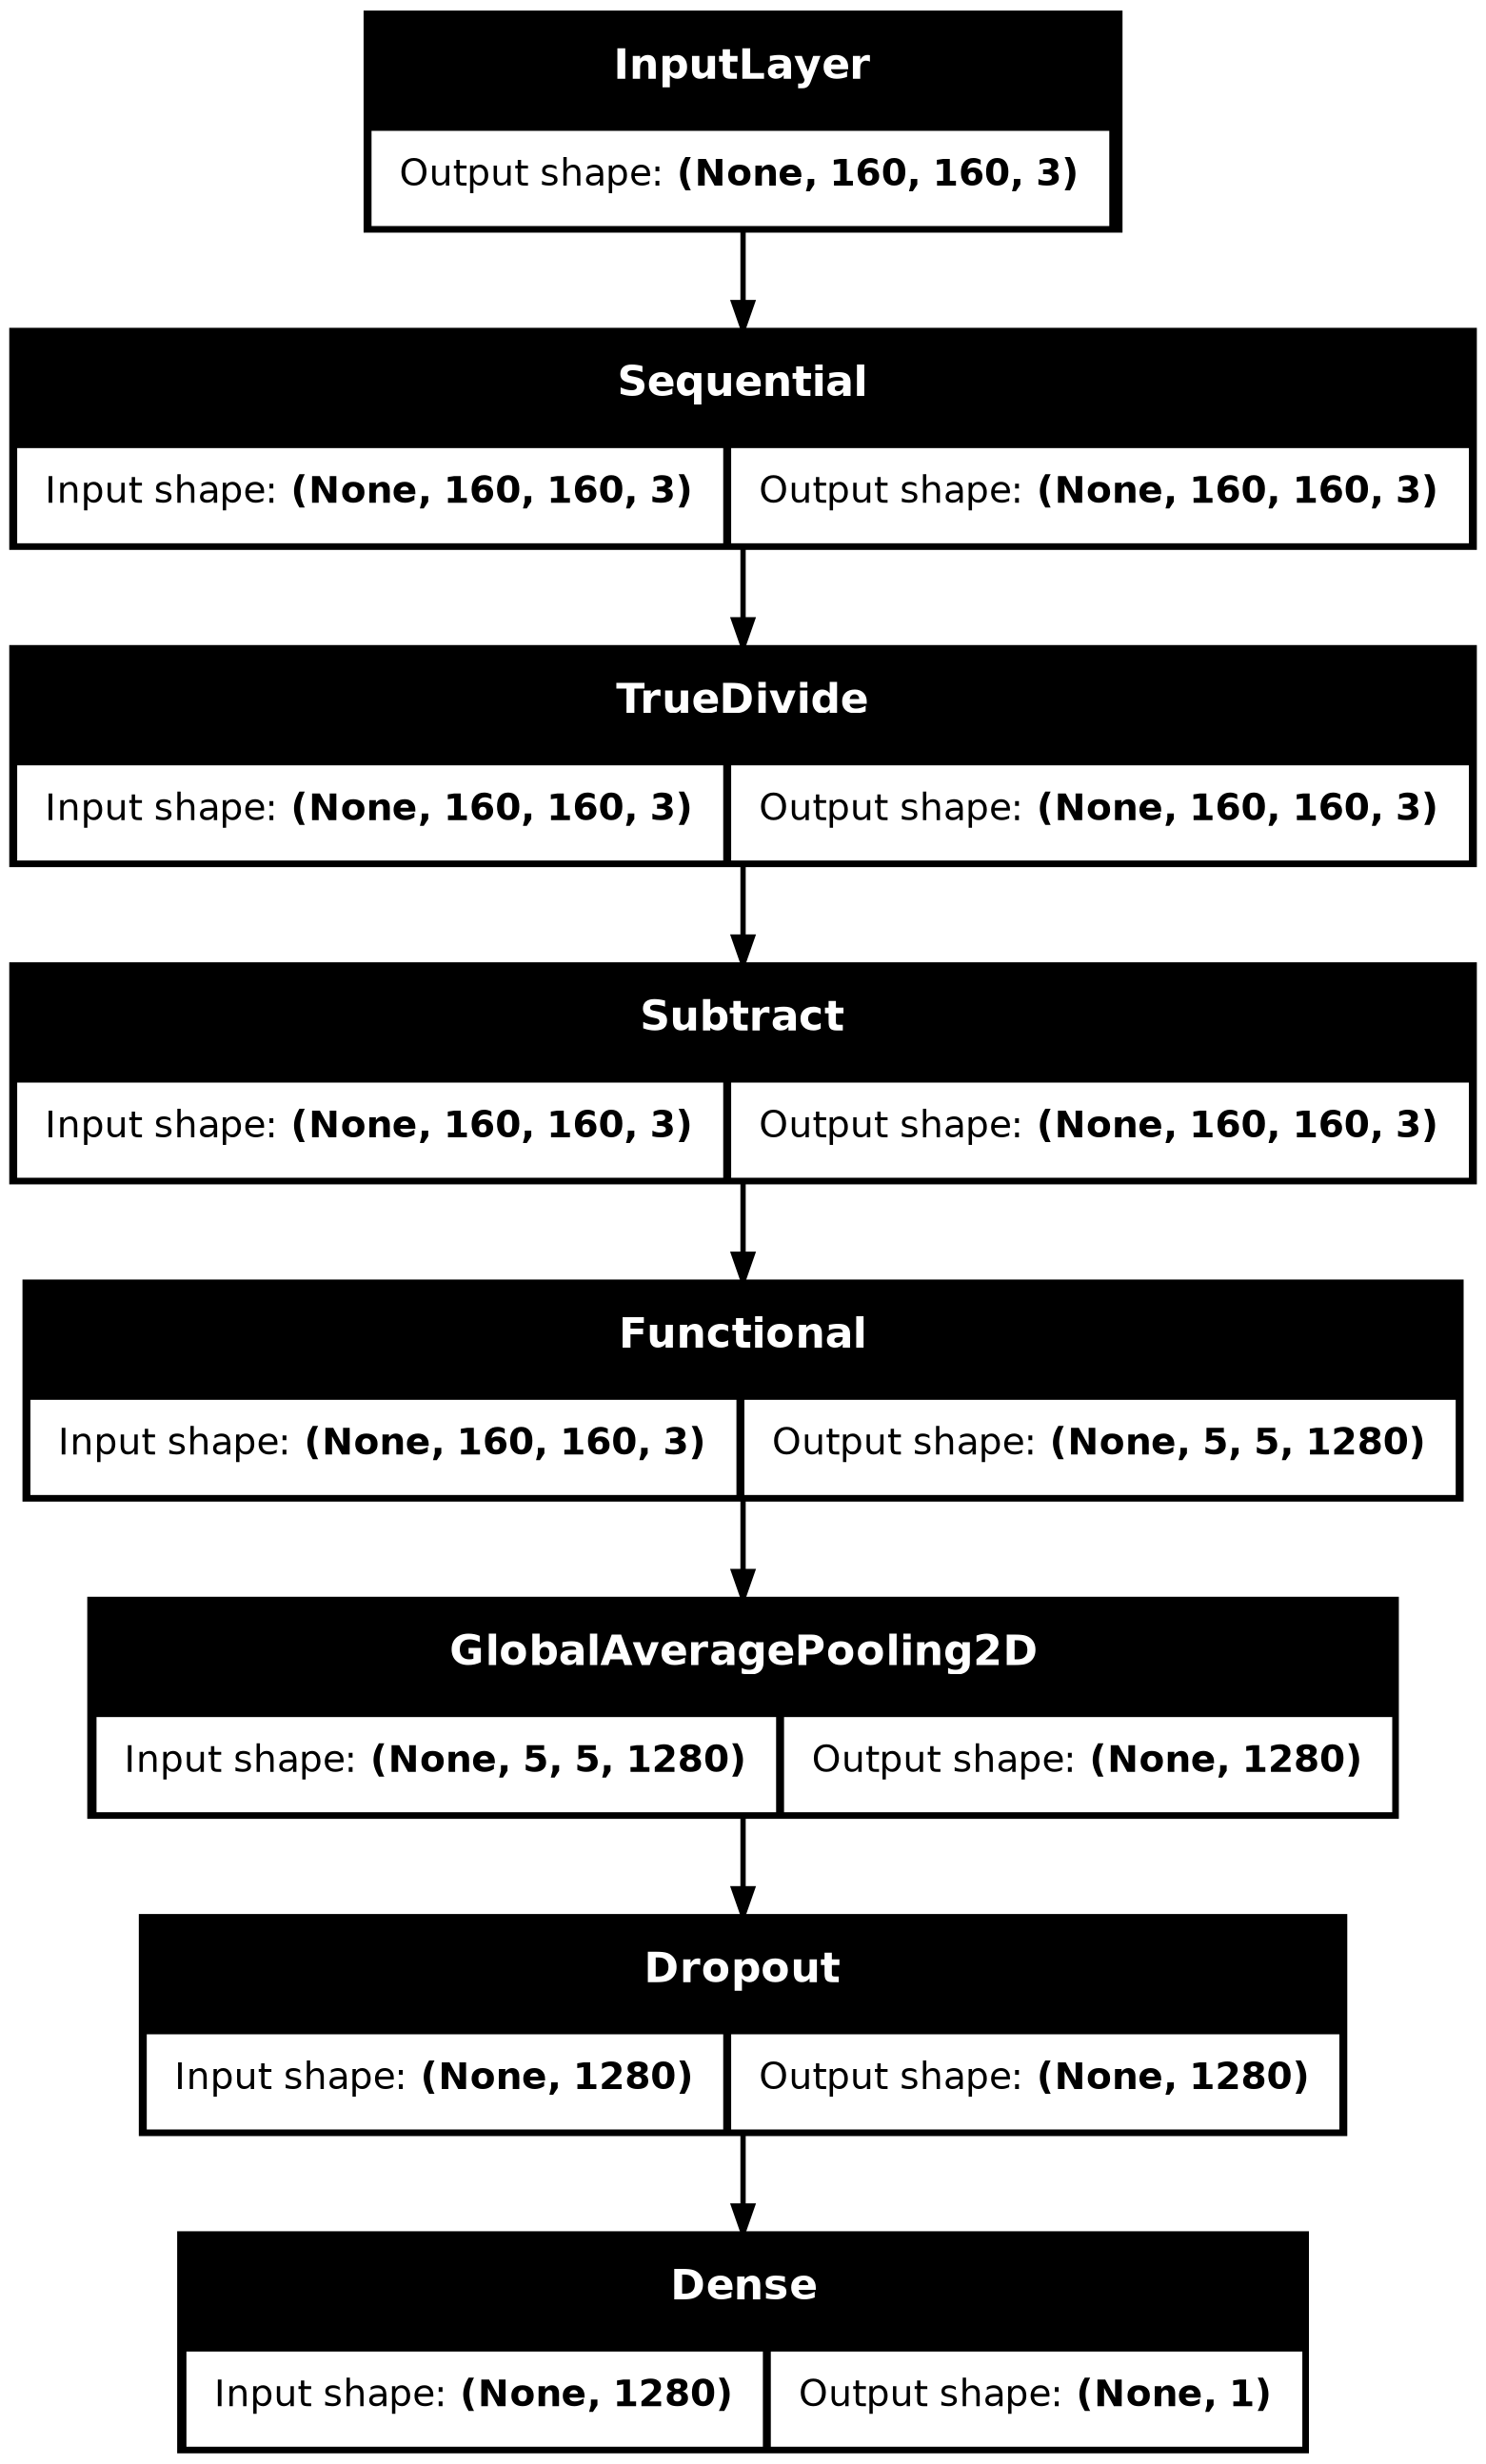

In [27]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [28]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5, name='accuracy')])


In [29]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))


26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.4047 - loss: 0.9256
initial loss: 0.93
initial accuracy: 0.40


In [30]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 55ms/step - accuracy: 0.5435 - loss: 0.7604 - val_accuracy: 0.6634 - val_loss: 0.6188
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.7290 - loss: 0.5505 - val_accuracy: 0.8478 - val_loss: 0.4353
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.7995 - loss: 0.4513 - val_accuracy: 0.9245 - val_loss: 0.3329
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.8650 - loss: 0.3637 - val_accuracy: 0.9443 - val_loss: 0.2697
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.8905 - loss: 0.3082 - val_accuracy: 0.9542 - val_loss: 0.2281
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.8960 - loss: 0.2888 - val_accuracy: 0.9629 - val_loss: 0.1957
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.9190 - loss: 0.2580 - val_accuracy: 0.9715 - val_loss: 0.1704
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.9070 - loss: 0.2439 - val_accuracy: 0.9740 - v

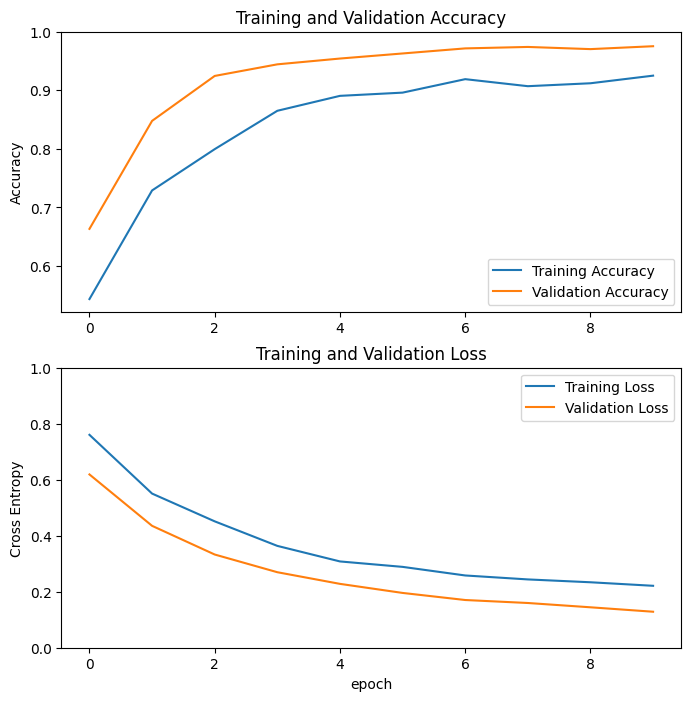

In [31]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


In [32]:
base_model.trainable = True

In [33]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False


Number of layers in the base model:  154


In [34]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5, name='accuracy')])


In [35]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,862,721 (7.11 MB)

 Non-trainable params: 396,544 (1.51 MB)

In [36]:
len(model.trainable_variables)

56

In [37]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=len(history.epoch),
                         validation_data=validation_dataset)


Epoch 11/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 14s 87ms/step - accuracy: 0.8435 - loss: 0.3492 - val_accuracy: 0.9851 - val_loss: 0.0800
Epoch 12/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - accuracy: 0.9065 - loss: 0.2521 - val_accuracy: 0.9851 - val_loss: 0.0659
Epoch 13/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - accuracy: 0.9105 - loss: 0.2266 - val_accuracy: 0.9851 - val_loss: 0.0568
Epoch 14/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - accuracy: 0.9300 - loss: 0.1902 - val_accuracy: 0.9851 - val_loss: 0.0537
Epoch 15/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - accuracy: 0.9305 - loss: 0.1742 - val_accuracy: 0.9889 - val_loss: 0.0441
Epoch 16/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - accuracy: 0.9325 - loss: 0.1650 - val_accuracy: 0.9876 - val_loss: 0.0426
Epoch 17/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - accuracy: 0.9490 - loss: 0.1437 - val_accuracy: 0.9851 - val_loss: 0.0460
Epoch 18/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - accuracy: 0.9455 - loss: 0.1370 - val_accuracy: 0

In [38]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']


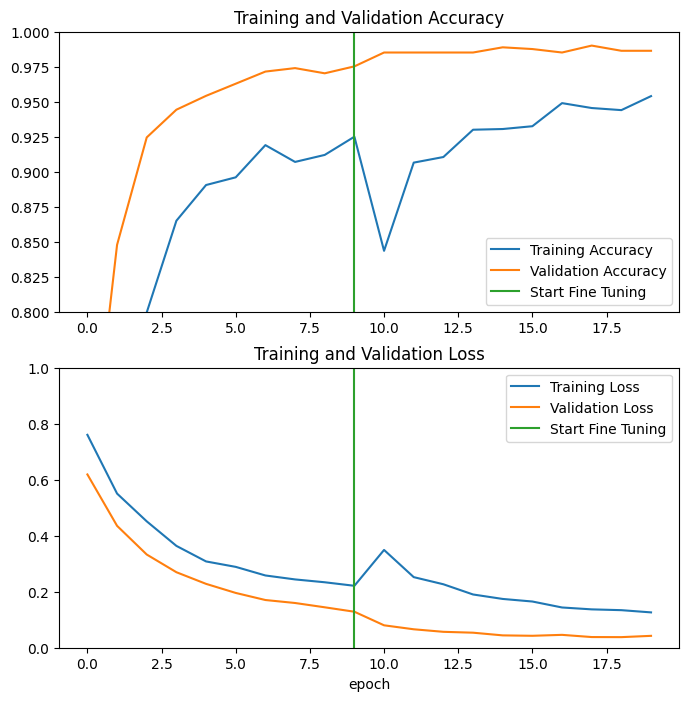

In [39]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


In [40]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9896 - loss: 0.0515
Test accuracy : 0.9895833134651184


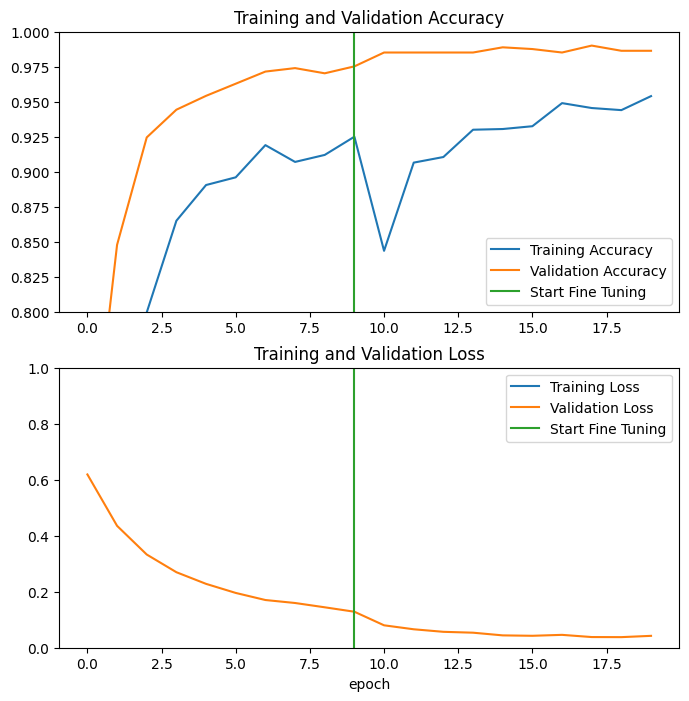

In [41]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()
